<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. 

This notebook illustrates the use of __Spark in SWAN to access CERN Accelerator logging service data__.

### Connect to the cluster (NXCals)

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Read the NxCALS device properties into spark dataframe

In [1]:
# creation of SQLContext is required to convert java dataframe to python dataframe
from pyspark import SQLContext
sqlContext = SQLContext(sc)

# source the nxcals python libs
from cern.nxcals.pyquery.builders import *
from pyspark.sql import DataFrame

# build the query and load data into spark dataframe
df1 = DevicePropertyQuery() \
            .builder(spark) \
            .system("CMW") \
            .startTime("2018-04-29 00:00:00.000") \
            .endTime("2018-05-01 00:00:00.000") \
            .entity() \
            .parameter("RADMON.PS-10/ExpertMonitoringAcquisition") \
            .buildDataset()
   
# convert to python dataframe
df1 = DataFrame(df1, sqlContext)

### Inspect data

In [2]:
df1.select('acqStamp','voltage_18V','current_18V','device','pt100Value').toPandas()[:5]

,acqStamp,voltage_18V,current_18V,device,pt100Value
0,1524960103132865000,NaN,37.301794,RADMON.PS-10,106.578911
1,1524960284134584000,NaN,NaN,RADMON.PS-10,107.246742
2,1524960322134942000,NaN,37.560940,RADMON.PS-10,106.504707
3,1524960353135244000,20.099066,NaN,RADMON.PS-10,107.068654
4,1524960911140548000,20.111261,37.698135,RADMON.PS-10,106.578911


### Draw a plot with matplotlib

In [3]:
import matplotlib
import pandas as pd
%matplotlib inline

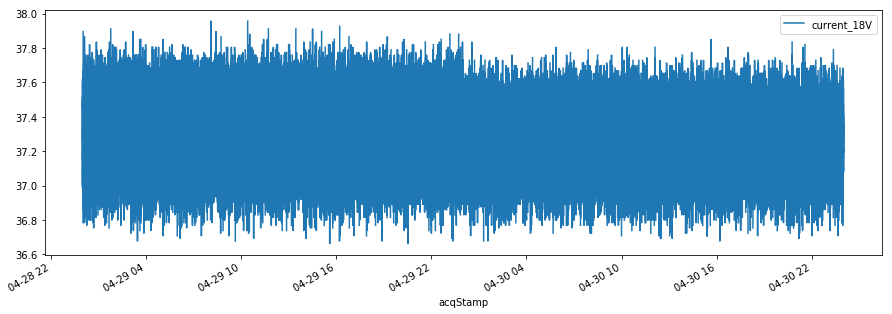

In [4]:
p_df = df1.select('acqStamp','current_18V').toPandas()
p_df.sort_values(by='acqStamp').plot(pd.to_datetime(p_df['acqStamp'],unit='ns'),'current_18V',figsize=(15,5))

### Read TGM data

In [5]:
tgmData = DevicePropertyQuery() \
                .builder(spark) \
                .system("CMW") \
                .startTime("2018-04-29 00:00:00.000") \
                .endTime("2018-05-01 00:00:00.000") \
                .entity() \
                .device("CPS.TGM") \
                .property("FULL-TELEGRAM.STRC") \
                .buildDataset()

tgmData = DataFrame(tgmData, sqlContext)

In [6]:
tgmData.toPandas()[:2]

,BATCH,BEAMID,BPNM,COMLN,CYCLE,CYTAG,DEST,DEST2,DURN,FREE14,...,USER,__record_timestamp__,__record_version__,acqStamp,class,cyclestamp,device,nxcals_entity_id,property,selector
0,0,56006,22,None,19,None,EAST_N,NTOF,2,None,...,EAST2,1524960105100000000,0,1524960105000000000,CPS.TGM,1524960105100000000,CPS.TGM,46955,FULL-TELEGRAM.STRC,CPS.USER.ALL
1,0,52324,5,None,5,None,TT2_FTA,NONE,2,None,...,AD,1524960689500000000,0,1524960689400000000,CPS.TGM,1524960689500000000,CPS.TGM,46955,FULL-TELEGRAM.STRC,CPS.USER.ALL


In [7]:
tgmData.groupBy("USER").count().show()

+--------+-----+
|    USER|count|
+--------+-----+
|   EAST1|12343|
|      AD| 1572|
|    LHC4| 1090|
|     MD1|  303|
|     MD6|   32|
|    LHC2|  621|
|LHCPROBE|  295|
|    ZERO|46588|
|     MD3|  323|
|     MD2|   53|
|   EAST2| 9866|
|     TOF|21220|
|     MD5|   36|
|LHCINDIV| 2014|
| SFTPRO2|18241|
+--------+-----+



In [8]:
tgm_df_dump = tgmData.select("cyclestamp", "USER","DEST").where("DEST = 'PS_DUMP' AND USER != 'ZERO'")
tgm_df_dump.show()

+-------------------+----+-------+
|         cyclestamp|USER|   DEST|
+-------------------+----+-------+
|1524978263500000000| TOF|PS_DUMP|
|1524981028300000000| TOF|PS_DUMP|
|1524981834700000000| TOF|PS_DUMP|
|1524989380300000000| TOF|PS_DUMP|
|1524990273100000000| TOF|PS_DUMP|
|1524990589900000000| TOF|PS_DUMP|
|1524991828300000000| TOF|PS_DUMP|
|1524996321100000000| TOF|PS_DUMP|
|1524997444300000000| TOF|PS_DUMP|
|1524999748300000000| TOF|PS_DUMP|
|1524960868300000000| TOF|PS_DUMP|
|1524971322700000000| TOF|PS_DUMP|
|1524974663500000000| TOF|PS_DUMP|
|1524987047500000000| TOF|PS_DUMP|
|1524996839500000000| TOF|PS_DUMP|
|1524997703500000000| TOF|PS_DUMP|
|1524999229900000000| TOF|PS_DUMP|
|1524970343500000000| TOF|PS_DUMP|
|1524973741900000000| TOF|PS_DUMP|
|1524977053900000000| TOF|PS_DUMP|
+-------------------+----+-------+
only showing top 20 rows



### Read FTN data

In [9]:
data = DevicePropertyQuery() \
            .builder(spark) \
            .system("CMW") \
            .startTime("2018-04-29 00:00:00.000") \
            .endTime("2018-05-01 00:00:00.000") \
            .entity() \
            .device("FTN.QFO415S") \
            .property("Acquisition") \
            .buildDataset()
            
data = DataFrame(data, sqlContext)

In [10]:
data.toPandas()[:2]

,__record_timestamp__,__record_version__,acqStamp,acq_2,class,current,current_max,current_min,current_status,current_tola,current_tolr,current_unit,cyclestamp,device,nxcals_entity_id,property,selector
0,1524960240700000000,0,1524960240800238525,NaN,PowM1553,114.982834,NaN,NaN,None,NaN,NaN,None,1524960240700000000,FTN.QFO415S,54169,Acquisition,CPS.USER.ZERO
1,1524960276700000000,0,1524960276800238525,NaN,PowM1553,114.982086,NaN,NaN,None,NaN,NaN,None,1524960276700000000,FTN.QFO415S,54169,Acquisition,CPS.USER.TOF


In [11]:
data.describe("current").show()

+-------+--------------------+
|summary|             current|
+-------+--------------------+
|  count|              114597|
|   mean|  114.98358847391587|
| stddev|9.968958123980002E-4|
|    min|           114.97826|
|    max|           114.99046|
+-------+--------------------+



### Showing current sum for all *EAST* users:

In [12]:
from pyspark.sql.functions import sum
data.where("selector like '%EAST%'").select(sum(data.current)).show()

+------------------+
|      sum(current)|
+------------------+
|2553671.1740722656|
+------------------+



### Showing current sum for destination *TOF* using join:

In [13]:
tgmFiltered = tgmData.where("DEST like '%TOF%'")
tgmFiltered.count()
tgmFiltered.join(data, "cyclestamp").agg(sum(data.current)).show()

+------------------+
|      sum(current)|
+------------------+
|2291740.8582458496|
+------------------+

